#### Imports

In [1]:
import PyPDF2
import csv
import re
import json
import os
import us
import numpy as np

In [2]:
YEAR = 2005

# OCR with Adobe Acrobat and extraction with fitz

In [3]:
from __future__ import print_function
from itertools import groupby
import fitz
import matplotlib.pyplot as plt

### Extract text

In [4]:
#open PDF which has gone through Adobe Acrobat OCR
doc = fitz.open("directory_{}.pdf".format(YEAR))
print('Number of pages:', len(doc))

Number of pages: 731


In [5]:
def text_to_rows(text, threshold):
    '''
    Splits a list of into rows.
    Inputs:
        Text: a list of tuple containing individual words and their positions
        Threshold: the distance between lines
    Outputs:
        List of list that represent rows.
    '''
    if text == []:
        return []
    text_by_row = []
    temp = []
    init_y = text[0][1] #y0
    i = 0
    while i < len(text):
        if (text[i][1] < init_y + threshold) and (text[i][1] > init_y - threshold):
            temp.append(text[i][4])
        else:
            text_by_row.append(temp)
            temp = [text[i][4]]
            init_y = int(text[i][1])
        i += 1
    text_by_row.append(temp)
    return text_by_row

- Extract keys

In [6]:
abbr_keys = {}

In [7]:
#keys for treatment
pagen = 5
words = doc[pagen - 1].getText("words")
words = text_to_rows(words, 5)[3:-2]
for line in words:
    if re.match(r'(?:[A-Z-]+)$', line[0]):
        abbr_keys[line[0]] = ' '.join(line[1:])

In [8]:
#keys for language
pagen = 6
words = doc[pagen - 1].getText("words")
page6 = text_to_rows(words, 5)

In [9]:
key = 'N1'
val = ['Achumaw']
for line in page6[9:18]:
    for word in line:
        if word[-1].isnumeric():
            abbr_keys[key] = ' '.join(val)
            val = []
            key = word
        else:
            val.append(word)
    #abbr_keys[key] = ' '.join(val)

for line in page6[20:]:
    for word in line:
        if word[-1].isnumeric():
            abbr_keys[key] = ' '.join(val)
            val = []
            key = word
        else:
            val.append(word)
    abbr_keys[key] = ' '.join(val)

In [10]:
len(abbr_keys)

144

In [116]:
#add keys that not included in front pages but exists in other pages

In [24]:
# for i in range(1, 46):
#     if 'N' + str(i) not in abbr_keys:
#         abbr_keys['N' + str(i)] = None
#         print('N' + str(i))

- Explore text

In [25]:
# - explore the page set up - 
# select a page
firstpagen = 15
words = doc[firstpagen - 1].getText("words")

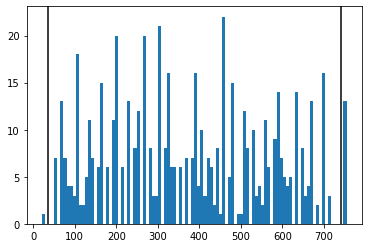

In [26]:
# check the y distribution to remove top and bottom crap...
y0s = [word[1] for word in words]
a = plt.hist(y0s, bins = 100)
plt.axvline(35, color='black')
plt.axvline(740, color='black')

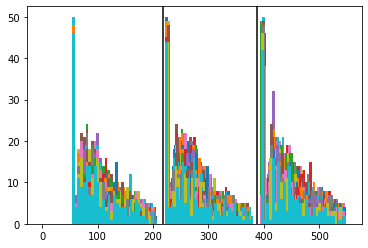

In [27]:
#to find column seperation
for pagen in range(100, 500):
    words = doc[pagen - 1].getText("words")
    words = [word for word in words if word[1] > 35]
    words = [word for word in words if word[1] < 740]
    x0s = [word[0] for word in words]
    a = plt.hist(x0s, bins = 100)
    
plt.axvline(218, color='black')
plt.axvline(388, color='black')

- Read text from PDF

In [28]:
def get_words_in_box(page, ulim, blim, col1lim, col2lim):
    '''
    Extract words from each column of the PDF.
    '''
    page_txt = []
    words = page.getText("words") 
    #cut off top and bottom
    words = [word for word in words if word[1] > ulim]
    words = [word for word in words if word[1] < blim]
    #get three columns
    page_txt.append(text_to_rows([word for word in words if word[0] < col1lim], 5))
    page_txt.append(text_to_rows([word for word in words if ((word[0] > col1lim) and (word[0] < col2lim))], 5))
    page_txt.append(text_to_rows([word for word in words if word[0] > col2lim], 5))
    return page_txt

In [33]:
#testing
#get_words_in_box(doc[firstpagen - 1], 35, 740, 217, 388)
#page with some blanck
#get_words_in_box(doc[24 - 1], 35, 740, 217, 388)

In [34]:
#run
data = []
for pagen in range(firstpagen, len(doc) + 1):
    data.append(get_words_in_box(doc[pagen-1], 35, 740, 217, 388))

# Write data into csv

- Checking + cleaning each part of data

In [35]:
#['SA', '�', 'TX', 'DT', 'MM', 'DM', '�', 'OP', '�', 'SF']
def is_keys(line):
    '''
    Check if the line (list of list) is a list of keys
    '''
    line = [key.replace('�', '') for key in line if (key != '�')]
    if not any(x not in abbr_keys for x in line):
        return True
    if line[0] in abbr_keys:
        if len(line) > 2 and line[1] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
        if len(line) > 3 and line[2] in abbr_keys:
            print("This line has more than 1 keys but not all, please check:", line)
    return False

def clean_keys(line):
    return '/'.join([key.replace('�', '') for key in line if (key != '�')]) + '/'

In [36]:
#['Nogales,', 'AZ', '85621']
#['Chesapeake', 'Beach,', 'MD', '20732']
def is_citystatezip(line):
    if line[-1].isnumeric() and len(line[-1]) == 5 and line[-2].isupper() and len(line[-2]) == 2 and line[-3][-1] == ',':
        return True
    return False

def clean_citystatezip(line):
    return [' '.join(line[:-2])[:-1], line[-2], line[-1]]

In [37]:
#['(205)', '216-0200'],
#['Intake:', '(205)', '216-0202'],
#['Hotlines:', '(888)', '950-4325', '(888)', '950HEAL']
#['6552x']
def is_contact(line):
    if line[0] == 'Intake:' or line[0] == 'Intakes:' or line[0] == 'Hotline:'or line[0] == 'Hotlines:':
        return True
    if len(line[0]) < 5:
        return False
    if line[0][0] == '(' and line[0][4] == ')' and line[0][1:4].isnumeric():
        return True
    if line[0][:4].isnumeric() and line[0][4] == 'x':
        return True
    return False

def clean_contact(line):
    l = ''
    for word in line:
        if len(word) == 5 and word[0] == '(':
            l += word
        else:
            l += word + ' '
    return l.strip()

In [38]:
address_indicators = ['P.0.', 'P.O', 'Road', 'Highway', 'Route', 'Building', 'Street', 'Avenue', 'Suite', 'Suites', 'Drive', 'Boulevard', \
                      'Annex', 'Streets','Floor', 'Fl', 'Bldg', 'Rear', 'Room', 'Basement', 'Building,', 'Attn:'] ##
name_indicators = ['Clinic', 'Medical', 'Inc', 'Health', 'Services', 'Treatment']

def is_address(line):
    if (not line[0].replace('-', '').isnumeric()) and any(x in line for x in name_indicators):
        return False
    if line[0].replace('-', '').isnumeric() or any(x in line for x in address_indicators):
        return True
    return False

In [39]:
# #for testing
# for page_data in data:
#     for col in page_data:
#         for line in col:
#             for word in line:
#                 if word[0] == 'F' and word[-1].isnumeric() and word not in abbr_keys:
#                     print(line)

- Split data into MOUDs

In [40]:
def split_col_data(col_text):
    '''
    Split column data into list of MOUD facilities.
    '''
    col_text_splitted = []
    temp = []
    i = 0
    while i < len(col_text) - 1:
        if is_keys(col_text[i]) and (not is_keys(col_text[i+1])):
            temp.append(col_text[i])
            col_text_splitted.append(temp)
            temp = []
        elif is_keys(col_text[i]) and (is_keys(col_text[i+1])):
            temp.append(col_text[i])
        else:
            if (not re.match(r'(?:[A-Z]+)$', ''.join(col_text[i]))):
                #if not keys and only upper characters, then ignore as name of city.
                temp.append(col_text[i])
        i += 1
    temp.append(col_text[-1])
    col_text_splitted.append(temp)
    return col_text_splitted

In [41]:
#split_col_data(data[2][2])

- Write data

In [42]:
def clean_col_data(col_text_splitted):
    '''
    Splits data into list of lists with
    name1, name2, address1, address2, city, state, zip, phone, keys
    '''
    data_holders = []
    for facil in col_text_splitted:
        if len(facil) < 2:
            print(facil)
        if len(facil) > 2:
            data_holder = []
            i = 0 #indicator of next line
            #name1
            data_holder.append(' '.join(facil[0])) 
            i += 1
            #name2
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('') 
            #name3
            if not is_address(facil[i]) and not is_citystatezip(facil[i]) and not is_contact(facil[i]): 
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')         
            #address1
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address2
            if not is_citystatezip(facil[i]) and not is_contact(facil[i]) and not is_keys(facil[i]):##
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #address3
            if is_address(facil[i]) and not is_citystatezip(facil[i]):
                data_holder.append(' '.join(facil[i])) 
                i += 1
            else:
                data_holder.append('')
            #city, state, zip
            data_holder += clean_citystatezip(facil[i])
            i += 1
            #contact
            if is_contact(facil[i]):
                data_holder.append(clean_contact(facil[i]))
                i += 1
                while i < len(facil):
                    if is_contact(facil[i]):
                        data_holder[-1] += ' ' + clean_contact(facil[i])
                        i += 1
                    else:
                        break
            else:
                data_holder.append('')
            #website
            if facil[i][0].split('.')[-1] == 'org' or facil[i][0].split('.')[0] == 'www' or facil[i][0].split('.')[-1] == 'com':
                data_holder.append(' '.join(facil[i]))
                i += 1
            else:
                data_holder.append('')
            #note
            if not is_keys(facil[i]):
                data_holder.append(' '.join(facil[i]))
                i += 1
            else:
                data_holder.append('')
            #keys
            data_holder.append('')
            for keys in facil[i:]:
                data_holder[-1] += clean_keys(keys)
            data_holders.append(data_holder)
            print(".", end = '') #for each MOUD
    return data_holders

In [43]:
filename = "{}.csv".format(YEAR)
with open(filename, 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(["Name1", "Name2", 'Name3', "Address1", "Address2", "Address3", "City", "State", "ZIP_Code", "Contact", "Website", "Note", "Keys"])

In [44]:
pagen = 15

for page in data:
    print("Page:", pagen, end = '')
    page_data_holders = []
    for col in page:
        if col != []:
            page_data_holders += clean_col_data(split_col_data(col))
            print(" Finished Col ", end = '')
    with open(filename, 'a', newline = '') as file:
        writer = csv.writer(file)
        writer.writerows(page_data_holders)
    pagen += 1
    print('')

Page: 15...... Finished Col ...... Finished Col ...... Finished Col 
Page: 16..... Finished Col ..... Finished Col ..... Finished Col 
Page: 17...... Finished Col ..... Finished Col ...... Finished Col 
Page: 18..... Finished Col ...... Finished Col ..... Finished Col 
Page: 19...... Finished Col ..... Finished Col ...... Finished Col 
Page: 20. Finished Col 
Page: 21...... Finished Col ..... Finished Col ..... Finished Col 
Page: 22..... Finished Col ...... Finished Col ..... Finished Col 
Page: 23..... Finished Col ...... Finished Col ..... Finished Col 
Page: 24.. Finished Col 
Page: 25..... Finished Col ..... Finished Col ..... Finished Col 
Page: 26..... Finished Col ..... Finished Col ...... Finished Col 
Page: 27..... Finished Col ...... Finished Col ..... Finished Col 
Page: 28...... Finished Col ..... Finished Col ...... Finished Col 
Page: 29...... Finished Col ...... Finished Col ...... Finished Col 
Page: 30..... Finished Col ...... Finished Col ..... Finished Col 
Page: 31

In [45]:
# #check error data
# no error

- Rewrite data in problem pages

In [46]:
# ^^

# Clean final data
- Replaced "A venue" with "A venue" in Address1
- Split ZIP code into two if in the format "35294-0018"
- To-do:
    - Clean up the wrong letters/numbers in address

In [11]:
import pandas as pd

In [48]:
df = pd.read_csv("{}.csv".format(YEAR))
df

,Name1,Name2,Name3,Address1,Address2,Address3,City,State,ZIP_Code,Contact,Website,Note,Keys
0,Lighthouse of Tallapoosa County Inc,Substance Abuse Rehab Program/Resid,NaN,36 Franklin Street,NaN,NaN,Alexander City,AL,35010,(256)234-4894,NaN,NaN,SA/TX/HH/RL/CO/MN/SF/
1,Anniston Fellowship House Inc,NaN,NaN,106 East 22nd Street,NaN,NaN,Anniston,AL,36201,(256)236-7229,NaN,NaN,SA/TX/HH/RL/SF/
2,Calhoun Cleburne Mental Health Center,New Directions,NaN,407 Noble Street,NaN,NaN,Anniston,AL,36201,(256)236-8003 Hotlines: (256)236-8003 (256)236...,NaN,NaN,SA/TX/OP/AD/CO/DU/SF/MD/SI/PI/MI/SS/
3,Bridge Inc,Recovery Center for Teens/Ashville,NaN,474 10th Street,NaN,NaN,Ashville,AL,35953,(205)594-3111,www.bridgeinc.org,NaN,SA/TX/OP/AD/SF/MD/SI/PI/MI/PA/AH/
4,Northwest Alabama Treatment Center,NaN,NaN,4204 Edmonton Drive,NaN,NaN,Bessemer,AL,35022,(205)425-1200 Hotline: (205)805-3381,NaN,Methadone Clients Only,SA/TX/DT/MM/DM/OP/CO/HV/PW/WN/BC/SF/PI/AH/
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11055,Wyoming Substance Abuse Treatment and,Recovery Centers (WYSTAR),NaN,1003 Saberton Street,NaN,NaN,Sheridan,WY,82801,(307)672-2044,www.wystarrecovery.com,NaN,SA/TX/HH/RL/OP/PH/PW/WN/BC/SF/SI/PI/MI/SS/
11056,Wyoming Substance Abuse Treatment and,Recovery Centers (WYSTAR),NaN,1898 Fort Road,Building 64,NaN,Sheridan,WY,82801,(307)673-2510 Intake: (307)672-2044,www.wystarrecovery.com,NaN,SA/TX/RL/OP/CO/HV/GL/SE/MN/CJ/SF/PI/MI/SS/AH/
11057,Hot Springs County Counseling Service,NaN,NaN,121 South 4th Street,NaN,NaN,Thermopolis,WY,82443,(307)864-3138 Intake: (307)864-2247,NaN,NaN,MH/TX/OP/DU/SF/MD/SI/PI/MI/SS/PA/
11058,Peak Wellness Center,Substance Abuse Services,NaN,103 Park Avenue,NaN,NaN,Wheatland,WY,82201,(307)322-3190,www.sewmhc.org/programstaps.htm,NaN,MH/TX/OP/AD/CO/DU/SF/MD/MC/SI/PI/MI/


In [49]:
#check if all state names are right
for index, row in df.iterrows():
    #print(row)
    if len(row[7])!=2:
        print(row)

In [50]:
#check if all zip codes are correct
df.dtypes

Name1       object
Name2       object
Name3       object
Address1    object
Address2    object
Address3    object
City        object
State       object
ZIP_Code     int64
Contact     object
Website     object
Note        object
Keys        object
dtype: object

- Correct in Pandas

In [51]:
#if address 1 and 2 should actually be one line...
for index, row in df.iterrows():
    if row[0].split()[-1] == 'and':
        if pd.isnull(row[1]):
            print(index)
        else:
            df.at[index, 'Name1'] = row[0] + ' ' + row[1]
            df.at[index, 'Name2'] = ''

In [52]:
# def split_zip(zipc):
#     if '-' in zipc:
#         return zipc.split('-')
#     return [zipc, None]
# #split zip-code if zip code is in the format xxxxx-xxxx
# df['zip1'] = [split_zip(zipc)[0] for zipc in df['ZIP_Code']]
# df['zip2'] = [split_zip(zipc)[1] for zipc in df['ZIP_Code']]

In [53]:
df.to_csv('{}_c.csv'.format(YEAR), index = False)

## Summary stats

- Check keys

In [12]:
df = pd.read_csv('{}_c.csv'.format(YEAR))

In [13]:
Methadone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Methadone' in val) or ('methadone' in val):
            Methadone_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [14]:
Buprenorphine_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Buprenorphine' in val) or ("buprenorphine" in val):
            Buprenorphine_keys.append(key)
            print(key, val)

MM Methadone maintenance (facility may also use buprenorphine in maintenance)
DM Methadone detoxification (facility may also use buprenorphine in detoxification)


In [15]:
Naltrexone_keys = []
for key, val in abbr_keys.items():
    if val:
        if ('Naltrexone' in val) or ('naltrexone' in val):
            Naltrexone_keys.append(key)
            print(key, val)

- Count keys

In [19]:
def count_key(df, key):
    '''
    Count the number MOUD with a certain key
    '''
    df[key] = df.apply(lambda row: key in row['Keys'].split('/'), axis = 1)
    return len(df[df[key] == True])

In [64]:
len(df)

11060

In [65]:
keys = []
labels = []
MOUD_numbers = []

In [66]:
for key in Methadone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    keys.append(key)
    xlabel = (abbr_keys[key] + '(' + key + ')').split()
    labels.append('\n'.join([' '.join(xlabel[i:i+3]) for i in range(0, len(xlabel), 3)]))
    MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [67]:
for key in Buprenorphine_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if key not in keys:
        xlabel = (abbr_keys[key] + '(' + key + ')').split()
        labels.append('\n'.join([' '.join(xlabel[i:i+3]) for i in range(0, len(xlabel), 3)]))
        MOUD_numbers.append(n_MOUD_with_key)

MM : Methadone maintenance (facility may also use buprenorphine in maintenance) 		 925
DM : Methadone detoxification (facility may also use buprenorphine in detoxification) 		 664


In [68]:
for key in Naltrexone_keys:
    n_MOUD_with_key = count_key(df, key)
    print(key, ":", abbr_keys[key], '\t\t', n_MOUD_with_key)
    if key not in keys:
        xlabel = (abbr_keys[key] + '(' + key + ')').split()
        labels.append('\n'.join([' '.join(xlabel[i:i+3]) for i in range(0, len(xlabel), 3)]))
        MOUD_numbers.append(n_MOUD_with_key)

In [69]:
labels

['Methadone maintenance (facility\nmay also use\nbuprenorphine in maintenance)(MM)',
 'Methadone detoxification (facility\nmay also use\nbuprenorphine in detoxification)(DM)']

In [70]:
MOUD_numbers

[925, 664]

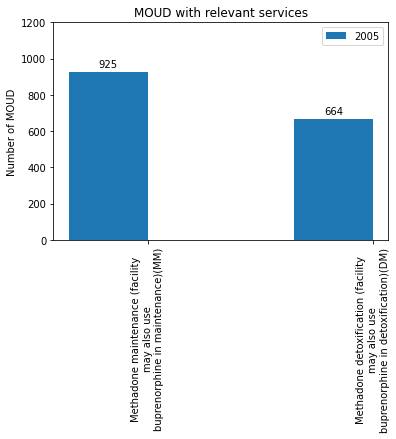

In [71]:
#barchart: https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, MOUD_numbers, width, label=str(YEAR))

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of MOUD')
ax.set_title('MOUD with relevant services')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

plt.ylim(0, 1200) #len(df)
plt.xticks(rotation=90)
plt.savefig('{}_stats.png'.format(YEAR), bbox_inches = 'tight', dpi = 300)